# Parallel beam

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

In [1]:
import sys
import numpy as np
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage
from Misc.Preview import Visualize3dImage
import matplotlib.pyplot as plt
# set the default size of all the plots
# if images are too big or too small try to play whit these numbers
plt.rcParams['figure.figsize'] = [10, 10] 
from Algorithms.SinogramGenerator_3D import SinogramGenerator_3D
from Geometry.ExperimentalSetupCT_3D import ExperimentalSetupCT_3D, Mode, DetectorShape

### Create a CT experimental setup

Now, we are going to create an experimental setup along with its geometry, by creating an instance of the ```ExperimentalSetupCT``` class. In this example, we are about to reconstruct 10 slices of the phantom, each with 100x100 pixels in the $x,y$ plane. The number of voxels in each direction is a derived parameter, calculated on top of ```image_matrix_size_mm``` (i.e., the numpy vector containing the lengths in mm of each side of the reconstruction volume) and ```voxel_size_mm``` (i.e, the numpy vector containing the lengths in mm of each side of the voxel).

In [2]:
# create CT experimental setup
my_experimental_setup = ExperimentalSetupCT_3D()
my_experimental_setup.mode = Mode.PARALLELBEAM
my_experimental_setup.detector_shape=DetectorShape.PLANAR
my_experimental_setup._detector_number = 2
# number of sensitive elements 
my_experimental_setup.pixels_per_slice_nb=100
my_experimental_setup.detector_slice_nb=100
my_experimental_setup.slice_pitch_mm=1
# number of rotation of the gantry
my_experimental_setup.gantry_angles_nb = 300
# range of the rotation
my_experimental_setup.angular_range_deg = 180
# fov size in mm 
my_experimental_setup.image_matrix_size_mm = np.array([100,100,100])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([1,1,1])

# compute the geometry
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())

self._pixel_pos_mm["x"].shape, self._source_pos_mm["x"].shape:  (20000,) (20000,)
p0:  [(-49.5       , -100.        ,  -49.5)
 (-48.5       , -100.        ,  -49.5)
 (-47.5       , -100.        ,  -49.5) ...
 (-48.01574886,  -48.99987614, -100. )
 (-49.01569403,  -48.98940435, -100. )
 (-50.0156392 ,  -48.97893257, -100. )]
p1:  [(-49.5       , 100.        , -49.5) (-48.5       , 100.        , -49.5)
 (-47.5       , 100.        , -49.5) ...
 (-48.01574886, -48.99987614, 100. ) (-49.01569403, -48.98940435, 100. )
 (-50.0156392 , -48.97893257, 100. )]
detector_type: DetectorType.CT
mode: Mode.PARALLELBEAM
detector_shape: DetectorShape.PLANAR
pixels_per_slice_nb: 100
detector_slice_nb: 100
slice_pitch_mm: 1
gantry_angles_nb: 300
angular_range_deg: 180
image_matrix_size_mm: [100 100 100]
voxel_size_mm: [1 1 1]
number of projections: 6000000


### Display the experimental setup

The ```Draw()``` method of the ```ExperimentalSetupCT``` class will allow us to display the geometry (source and detector position(s), as well as the reconstruction matrix). When using ```use_jupyter=1```, only a static figure will be displayed in the notebook itself. Otherwise, the user can obtain an interactive display of the same geometry by putting ```use_jupyter=0``` as the first argument. The second argument is the position of the camera in the static (```use_jupyter=1```) mode.

In [ ]:
my_experimental_setup.Draw(use_jupyter=0,camera_pos_mm=(0,-400,100))

### Load the image used to generate the sinogram

We are now ready to lead the example dataset provided, a voxelised 3D version of the Shepp-Logan head phantom (defined in the great PhD thesis of Enrik Turbell at Linkopings University - https://people.csail.mit.edu/bkph/courses/papers/Exact_Conebeam/Turbell_Thesis_FBP_2001.pdf). Upon loading the dataset, made up by a (rather coarse) grid of 100$^3$ voxels, we will select just 10 consecutive slices around the plane containing the well known triplet of small low-contrast details.

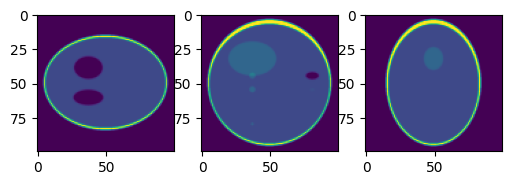

In [3]:
img = np.fromfile("../Data/SheppLogan3D_100x100x100_16bit_us.raw",dtype=np.uint16).reshape((100,100,100))
img = np.transpose(img, (1,2,0))

fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(img[50,:,:])
ax[1].imshow(img[:,50,:])
ax[2].imshow(img[:,:,50])

By calling the ```Visualize3dImage()``` method from ```Misc.Preview```, we can easily display the loaded volume by interactively selecting the slice (use the slider at the bottom of the figure).

### Generate and display the sinogram

The phantom data stored in the numpy 3D array ```img``` is now ready to be forward projected using the Siddon method (see Chapter 5 of the book). Fist of all, we must create an instance of the ```SinogramGenerator``` class, which takes the experimental setup as the only argument. Then, a sinogram object ```sino``` is created with the method ```GenerateObjectSinogram()``` of the ```SinogramGenerator``` class, taking the voxelised array as input. The ```transpose_image=1``` argument is required internally, in order to keep coherence between the array axes in the implementation of the Siddon algorithm. 

In most PC, the forward projection step in this example shuold last no longer than 1 minute or so. It will increase if the projection grid is made finer, or more slices are put in the computation.

In [4]:
s=SinogramGenerator_3D(my_experimental_setup)
sino_list=s.GenerateObjectSinogram(img,transponse_image=1)

for s in sino_list: 
    print('sino_list[s].shape: ' , s._data.shape)

index:  0
index:  3000000, 50% done...
sino_list[s].shape:  (100, 300, 100)
sino_list[s].shape:  (100, 300, 100)


Let's now visualize the resulting sinogram, slice by slice, again by calling the ```Visualize3dImage``` method. As it can be seen, the angular coordinate is displayed in the horizonal axis and the radial coordinate in the vertical axis. The number of bins in both directions is defined in the experimental setup.

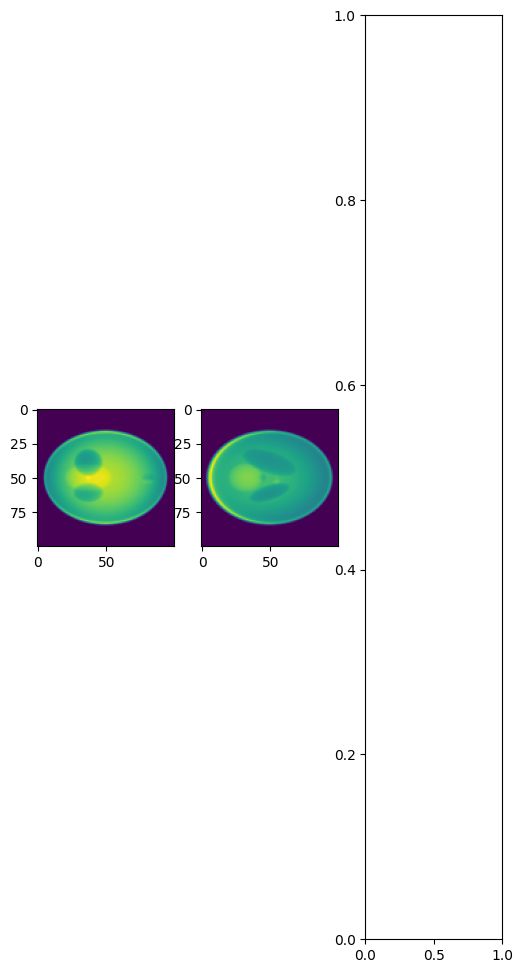

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(6,12))
ax[0].imshow(sino_list[0]._data[:,0,:])
ax[1].imshow(sino_list[1]._data[:,0,:])
#ax[2].imshow(sino_list[2]._data[:,0,:])

### Run the FBP algorithm and display the reconstructed image

Let us now reconstruct the sinograms. The theory behind FBP reconstruction is described in Chapter 3 of the book. First, we create a ```FBP``` object called ```f```, and we assign the previously generated sinogram object to its member ```f.sinogram```. The type of interpolation to be used in the backprojection step is stored in ```f.interpolator``` (see comments in the code).

In [ ]:
f=FBP()
f.sinogram=sino
# this is the interpolation for the backprojection 
# available options are : "linear","nearest","zero","slinear","quadratic","cubic"
# see for https://docs.scipy.org/doc/scipy/reference/generated/szerocipy.interpolate.interp1d.html parameter: kind
# for an explanation of the interpolation parameters  
f.interpolator='cubic'


Ready? The next line will make the FBP reconstruction to start, finally! Some text message will appear to let the user know the progress status of the reconstruction during the computation, even though this example shuold run quite fast in most PC's.

In [ ]:
f.Reconstruct()


If you can read ```Reconstruction done``` in the log text above, then you're done. All the slices have been reconstruction, so let's display them now. The result is stored in ```f._image```, so let's put this object as argument in the ```Visualize3dImage()``` method.

In [ ]:
# We are rotating 180° the image before displaying it, this is required due to 
# the internal implementation of the backprojection function in order to make it
# perfectly comparable with the original one.
f._image = np.rot90(f._image,2)
Visualize3dImage(f._image)

In this FBP demo in parallel beam geometry, we used the DAPHNE framework as a high-level, easy to use API to run all the tasks relevant for the reconstruction. Some other notebook in this folder wil avoid DAPHNE, so the user will see all the hard computation steps at "low"-level. 
We can now explore a bit more some relevant building block. For instance, let's see the shape of the ramp filter in the spatial and frequency domain.
As explained in Chapter 3 of the book, the frequency response of the ramp filter, $H(\nu)$ is intrinsically a 1D function of the spatial frequency. Indeed, to make things more "pythonic", in our code within DAPHNE we are storing repeated copies of the 1D filter function in a multidimensional array called ```_Hm``` (where 'm' stands for 'matrix'). With this trick, the filtration in the frequency domain of the sinogram is just performed by multiplying (internally, in the ```f.Reconstruct()``` method) the FFT of the sinogram of each slice with the ```_Hm``` function.

In [ ]:
plt.figure()
plt.plot(f._Hm[:,0])
plt.title("Ramp filter freq. response")


In the Figure above, the negative frequencies appear in the second half of the plot (i.e., for $N_{bin}/2 \leq k < N_{bin}/2 - 1$). Let's now display also the impulse response of the filter, $h(x')$.

In [ ]:
plt.figure()
plt.title("Ramp filter impulse response")
plt.plot(f._h)

As a last step in this exercise, let's visualize the filtered sinogram stored in ```f._filtered_sinogram```:

In [ ]:
Visualize3dImage(f._filterderd_sinogram,2)